# NYC-Taxi-FHV-Project


In [56]:
import pandas as pd #DataFrame
import numpy as np #For array
import os #for os commands
from math import sin, cos, sqrt, atan2, radians, log #For calculation
import time           #to get the system time
import datetime       #for datetime operations
import holidays       #For extract date time of holidays
import calendar       #For calendar for datetime operations


pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYU-Taxi-project/My First Project-b3735f3b3a9d.json"
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./My Project 14295-223aab171173.json"
from google.cloud import bigquery
client = bigquery.Client()

#For geospatial data
import geopandas as gpd   #For geospatial data
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import geohash_hilbert as ghh # For geohash code
import shapefile

#For machine learning models
import sklearn
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge #For lasso and ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#For visualization purpose
from scipy.misc import imread, imresize, imsave 
from pandas.plotting import scatter_matrix
import scipy         #for other dependancies
import seaborn as sns #for making plots
from scipy.misc import imread, imresize, imsave  
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
from scipy.misc import imread, imresize, imsave  
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

## 1. Data Processing

### 1.1 Query Taxi Data from BigQuery

In [69]:
start = time.time()
query = (
"""
SELECT x.travel_time,
    pickup_datetime,
    dropoff_datetime,
    x.date,
    x.month,
    x.day,
    FORMAT_DATE('%A', x.date) as wkday,
    pick_hour,
    pickup_location_id,
    dropoff_location_id,
    'Taxi' as type,
    wdsp as AWND,
    prcp as PRCP,
    snow_ice_pellets as SNOW,
    sndp as SNWD,
    max as TMAX,
    min as TMIN
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date, pick_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_location_id, dropoff_location_id,
            EXTRACT (HOUR FROM pickup_datetime) as pick_hour,
            EXTRACT (DAY FROM pickup_datetime) as day,
            EXTRACT (MONTH FROM pickup_datetime) as month,
            EXTRACT (DATE FROM pickup_datetime) as date,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time,
            passenger_count
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
      ) x
      where x.travel_time > 0 and pickup_location_id <= '263' and dropoff_location_id <= '263'
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2018` where stn='725053'
) y on x.month = y.month and x.day = y.day
where x.row_number <= 20
"""
)
Taxi = pd.io.gbq.read_gbq(query,dialect='standard')
       
end = time.time()
print("Time taken by above cell is {} mins.".format(round((end-start)/60,2)))

Time taken by above cell is 0.6 mins.


### 1.2 Combine and Clean Taxi and FHV Data

Loading and combining Uber, Lyft,Via data from local to Taxi data

In [71]:
FHV = pd.read_csv('../Data/1-12_weather_mini.csv')
data = pd.concat([Taxi, FHV], axis=0, sort=False)
data.head()

,travel_time,pickup_datetime,dropoff_datetime,date,month,day,wkday,pick_hour,pickup_location_id,dropoff_location_id,type,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,483,2018-03-07 13:02:47,2018-03-07 13:10:50,2018-03-07 00:00:00,3,7,Wednesday,13,170,141,Taxi,8.7,0.11,1,999.9,46.9,32.0
1,681,2018-03-07 13:47:54,2018-03-07 13:59:15,2018-03-07 00:00:00,3,7,Wednesday,13,163,230,Taxi,8.7,0.11,1,999.9,46.9,32.0
2,590,2018-03-07 13:24:32,2018-03-07 13:34:22,2018-03-07 00:00:00,3,7,Wednesday,13,233,224,Taxi,8.7,0.11,1,999.9,46.9,32.0
3,379,2018-03-07 13:51:58,2018-03-07 13:58:17,2018-03-07 00:00:00,3,7,Wednesday,13,186,246,Taxi,8.7,0.11,1,999.9,46.9,32.0
4,351,2018-03-07 13:27:14,2018-03-07 13:33:05,2018-03-07 00:00:00,3,7,Wednesday,13,162,237,Taxi,8.7,0.11,1,999.9,46.9,32.0


Generating **heatmap** to check missing value pattern, and also check missing value by each feature 

                     counts
AWND                  38825
dropoff_location_id      76
pickup_location_id        1
TMAX                      0
SNWD                      0
SNOW                      0
PRCP                      0
type                      0
travel_time               0
pickup_datetime           0
pick_hour                 0
wkday                     0
day                       0
month                     0
date                      0
dropoff_datetime          0
TMIN                      0


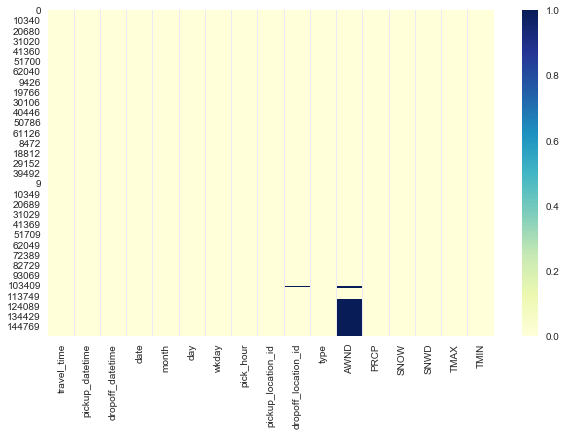

In [72]:
print(pd.DataFrame(data.isna().sum(axis=0),columns=['counts']).sort_values(by='counts',ascending=False))

plt.figure(figsize=(10,6))
sns.heatmap(data.isna(),cmap="YlGnBu")
plt.show()

Removing missing value for pickup and droppoff location, and replaceing `AWND` missing by median 

In [78]:
data.AWND.replace(np.NaN, data.AWND.median(), inplace=True)

data.dropna(axis=0, inplace=True)

data.pickup_location_id = data.pickup_location_id.astype(int)
data.dropoff_location_id = data.dropoff_location_id.astype(int)
data = data.loc[(data.dropoff_location_id <= 263) & (data.pickup_location_id <= 263), :]

### 1.3 Define Trip Distance

In [81]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["location_i", "longitude", "latitude"])

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

# great circle distance
def haversine_(lat1, lng1, lat2, lng2):
    """calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

# manhattan distance
def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

In [82]:
sf = shapefile.Reader("../Data/taxi_zones/geo_export_5c667c84-e344-4ff1-896e-9b2483684b97.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index('location_i'), on='location_i')
df_loc.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,longitude,latitude
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,-74.171533,40.689483
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,-73.822478,40.610824
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,-73.844953,40.865747
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,-73.977725,40.724137
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,-74.187558,40.550664


In [83]:
data.pickup_location_id = data.pickup_location_id.astype(int)
data.dropoff_location_id = data.dropoff_location_id.astype(int)

data_backup  = data.copy()

result = pd.merge(data, df_loc[['location_i', 'borough', 'zone', 'longitude', 'latitude']],
                  left_on = 'pickup_location_id', right_on = 'location_i', how='left').drop(columns='location_i')

result = pd.merge(result, df_loc[['location_i', 'borough', 'zone', 'longitude', 'latitude']],
                  left_on = 'dropoff_location_id', right_on = 'location_i', how='left').drop(columns='location_i')

result.columns = ['travel_time', 'pickup_datetime', 'dropoff_datetime', 'date', 'month','day', 'wkday', 'pick_hour', 'pickup_location_id',
                  'dropoff_location_id', 'type', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX','TMIN',
                  'pickup_borough', 'pickup_zone', 'pickup_longitude','pickup_latitude',
                  'dropoff_borough', 'dropoff_zone', 'dropoff_longitude', 'dropoff_latitude']
result.head()

,travel_time,pickup_datetime,dropoff_datetime,date,month,day,wkday,pick_hour,pickup_location_id,dropoff_location_id,type,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,pickup_borough,pickup_zone,pickup_longitude,pickup_latitude,dropoff_borough,dropoff_zone,dropoff_longitude,dropoff_latitude
0,483,2018-03-07 13:02:47,2018-03-07 13:10:50,2018-03-07 00:00:00,3,7,Wednesday,13,170,141,Taxi,8.7,0.11,1,999.9,46.9,32.0,Manhattan,Murray Hill,-73.977648,40.747725,Manhattan,Lenox Hill West,-73.959634,40.766952
1,681,2018-03-07 13:47:54,2018-03-07 13:59:15,2018-03-07 00:00:00,3,7,Wednesday,13,163,230,Taxi,8.7,0.11,1,999.9,46.9,32.0,Manhattan,Midtown North,-73.977041,40.764387,Manhattan,Times Sq/Theatre District,-73.984196,40.759817
2,590,2018-03-07 13:24:32,2018-03-07 13:34:22,2018-03-07 00:00:00,3,7,Wednesday,13,233,224,Taxi,8.7,0.11,1,999.9,46.9,32.0,Manhattan,UN/Turtle Bay South,-73.969980,40.749124,Manhattan,Stuy Town/Peter Cooper Village,-73.976981,40.731710
3,379,2018-03-07 13:51:58,2018-03-07 13:58:17,2018-03-07 00:00:00,3,7,Wednesday,13,186,246,Taxi,8.7,0.11,1,999.9,46.9,32.0,Manhattan,Penn Station/Madison Sq West,-73.992434,40.748496,Manhattan,West Chelsea/Hudson Yards,-74.003811,40.752412
4,351,2018-03-07 13:27:14,2018-03-07 13:33:05,2018-03-07 00:00:00,3,7,Wednesday,13,162,237,Taxi,8.7,0.11,1,999.9,46.9,32.0,Manhattan,Midtown East,-73.972471,40.756840,Manhattan,Upper East Side South,-73.965635,40.768614


In [27]:
data['haversine_distance'] = round(haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)
data['manhattan_distance'] = round(manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

E:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arcsin


In [68]:
result.dropoff_location_id.max()

265

In [90]:
round(haversine_(result.pickup_latitude,result.pickup_longitude,result.dropoff_latitude,result.dropoff_longitude),3)[round(haversine_(result.pickup_latitude,result.pickup_longitude,result.dropoff_latitude,result.dropoff_longitude),3).isna()]

E:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in arcsin


178483   NaN
181317   NaN
184459   NaN
192753   NaN
195536   NaN
195537   NaN
195538   NaN
195539   NaN
207014   NaN
235301   NaN
238332   NaN
244776   NaN
245243   NaN
248081   NaN
251703   NaN
252078   NaN
263605   NaN
265065   NaN
269677   NaN
271745   NaN
274630   NaN
276050   NaN
279285   NaN
280083   NaN
285815   NaN
288674   NaN
293314   NaN
294455   NaN
295716   NaN
300501   NaN
301394   NaN
314949   NaN
dtype: float64

In [91]:
result.iloc[178483,]

travel_time                                        1285
pickup_datetime                    2018-02-03T22:09:58Z
dropoff_datetime                   2018-02-03T22:31:23Z
date                                         2018-02-03
month                                                 2
day                                                   3
wkday                                          Saturday
pick_hour                                            22
pickup_location_id                                   57
dropoff_location_id                                  69
type                                               Uber
AWND                                               7.61
PRCP                                                  0
SNOW                                                  0
SNWD                                                  0
TMAX                                                 31
TMIN                                                 16
pickup_borough                                  

In [92]:
df_loc.loc[df_loc.location_i==57,:]

,borough,location_i,objectid,shape_area,shape_leng,zone,longitude,latitude


### 1.2 Remove Outlier

###  1.2.1 Remove Short & Large Distance

#### Some passengers get on taxi then get off immediately, so the time and distance is near zero. Many rows do have zero for pickup or drop off location or almost same location for pick up and drop off. 

#### Therefore, we are only considered the travel time is at least 60 second and no longer than 5 hours. And, we investage on the distance between 0 and 50 miles

In [ ]:
data.plot(x='haversine_distance',y='travel_time',kind='scatter')

In [ ]:
data.loc[(data.haversine_distance == 0) & (data.travel_time <= 60), ['travel_time', 'haversine_distance']].head(10)

In [ ]:
data = data.loc[(data['haversine_distance'] > 0.5) & (data['haversine_distance']<50)]

###  1.2.2 Remove Short & Large Trip Time

#### In NYC

In [ ]:
data = data.loc[(data['travel_time'] > 60) & (data['travel_time'] < 20000)]
data.plot(x='haversine_distance',y='travel_time',kind='scatter')

### 1.2.3 Clean GPS Coordinates

In [ ]:
# clean any pickup not in the NYC
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
data = data[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1])]
data = data[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1])]
data = data[(data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1])]
data = data[(data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1])]

### 1.2.4 Remove No Passenger Trip

In [ ]:
data = data.loc[data.passenger_count > 0]

### 1.2.5 Clean Weather Data

In [ ]:
# refill visib using forward or backward
data['visib'] = data['visib'].replace(999.9, np.nan).fillna(method='ffill')

# refill mxpsd using forward or backward
data['mxpsd'] = data['mxpsd'].replace(999.9, np.nan).fillna(method='ffill')              

# refill wdsp using forward or backward
data['wdsp'] = data['wdsp'].replace(999.9, np.nan).fillna(method='ffill')              

# refill gust as 0
data.loc[(data['gust'] == 999.9), 'gust'] = 0

# refit sndp as 0
data.loc[data['sndp'] == 999.9, 'sndp'] = 0

## 2. Exploratory Data Analysis & Process

### Trip Duration vs Hours, Day of Week and Month

#### Hourly Duration

In [ ]:
summary_hour_duration = pd.DataFrame(data.groupby('pickup_hour')['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", value="travel_time")
sns.despine(bottom = True)

In [ ]:
summary_hour_duration = pd.DataFrame(data.groupby(['weekday','pickup_hour'])['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="weekday", value="travel_time")
sns.despine(bottom = True)

In [ ]:
heatmap_data1 = summary_hour_duration.pivot(index = 'weekday',columns = 'pickup_hour',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
sns.heatmap(heatmap_data1, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

In [ ]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="pickup_hour", y="travel_time", data=data, palette="PRGn")
plt.ylim(120, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

####  Weekly Durations

In [ ]:
summary_week_duration = pd.DataFrame(data.groupby(['weekday'])['travel_time'].median())
summary_week_duration.reset_index(inplace = True)
summary_week_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_week_duration, time="weekday", unit = "unit", value="travel_time")
sns.despine(bottom = True)

In [ ]:
summary_weekday_duration = pd.DataFrame(data.groupby(['weekday','month_of_year'])['travel_time'].median())
summary_weekday_duration.reset_index(inplace = True)
summary_weekday_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_weekday_duration, time="weekday", unit = "unit", condition="month_of_year", value="travel_time")
sns.despine(bottom = True)

In [ ]:
heatmap_data2 = summary_weekday_duration.pivot(index = 'month_of_year',columns = 'weekday',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
ax.axis
sns.heatmap(heatmap_data2, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

In [ ]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="weekday", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

#### Monthly Duration

In [ ]:
summary_month_duration = pd.DataFrame(data.groupby(['month_of_year'])['travel_time'].median())
summary_month_duration.reset_index(inplace = True)
summary_month_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_month_duration, time="month_of_year", unit = "unit", value="travel_time")
sns.despine(bottom = True)

In [ ]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="month_of_year", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

### Summary of Weather Data

In [ ]:
df_weather = pd.read_csv("./Data/tables/weather_2016_cleaned.csv")

In [ ]:
df_weather.boxplot(figsize=(30,5))

In [ ]:
df_weather.hist(figsize=(8,15))

In [ ]:
corr = df_weather.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

### Weather vs Trip Duration

In [ ]:
df = data[['date_of_year','travel_time', 'temp','visib','mxpsd', 'wdsp', 'gust', 'max', 'min', 'prcp', 'sndp', 
             'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder']]
corr = df.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

## 3. Feature Engineer

### 3.1 Transformation of Trip Duration

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
ff, axes = plt.subplots(1,1, figsize=(8, 6), sharex=True)
sns.despine(left=True)

sns.distplot(data['travel_time'].values+1, axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

In [ ]:
data['travel_time'] = np.log(data['travel_time']).values+1

sns.set(style="white", palette="muted", color_codes=True)
ff, axes = plt.subplots(1,1, figsize=(8, 6), sharex=True)
sns.distplot(data['travel_time'], axlabel = 'Log Distance', label = 'Histogrqm of Distance', bins = 50, color="r")


### 3.2 Weekday

In [ ]:
data['weekday'] = data['date'].dt.weekday

### 3.3 Holiday

In [ ]:
us_holidays = holidays.UnitedStates()
data['holiday'] = data['date'].apply(lambda x: 1 if x in us_holidays else 0)

### 3.4 Rush Hour

In [ ]:
# create dummy for rush hour
data["rush_hour"] = 0
data.loc[(data["pickup_hour"] >= 8) & (data["pickup_hour"] <= 16),"rush_hour"] = 1

### 3.5 Bearing

In [ ]:
def bearing_array(lat1, lng1, lat2, lng2):
    """calculate bearing for each trip"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

data['bearing'] = round(bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

### 3.6 Airport Trip

In [ ]:
data['airport'] = 0
xlim = [-73.80, -73.77]
ylim = [40.63, 40.65]
data.loc[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1]) &
         (data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1]), 'airport'] = 1
data.loc[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1]) &
         (data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1]), 'airport'] = 1

xlim = [-73.88, -73.85]
ylim = [40.76, 40.78]
data.loc[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1]) &
     (data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1]), 'airport'] = 1
data.loc[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1]) &
     (data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1]), 'airport'] = 1

## K-means Cluster
#### Cluster pickup and dropoff locations¶

In [ ]:
start = time.time()
loc_df = pd.DataFrame()
loc_df['longitude'] = data.pickup_longitude
loc_df['latitude'] = data.pickup_latitude
loc_df["dropoff_lat"] = data.dropoff_latitude
loc_df['dropoff_long'] = data.dropoff_longitude

kmeans = KMeans(n_clusters=25, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 10)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60,2)))
    
plt.title('Clusters of New York')
plt.show()

data['cluster'] = loc_df.label

### Geohash

#### Add geohash to represent location

In [ ]:
start = time.time()
pickup = []
dropoff = []
for i in range(len(data)):
    
    dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))


data['dropoff_geo'] = dropoff
data["dropoff_geo_recode"] = data["dropoff_geo"].astype('category').cat.codes

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60,2)))

#### Plot geohash map

In [ ]:
from IPython.display import Image
Image(filename='geohash_pickup.png', width=500, height=300)

### Taxi Zone

## 4. Optimize the memory usage

In [ ]:
data = data.drop(['wdsp', 'gust', 'snow_ice_pellets', 'hail', 'thunder','dropoff_geo'], axis = 1)

In [ ]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj = obj.iloc[:,0:7]
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

In [ ]:
data.head()

## Modeling

In [ ]:
selected_features = ['month', 'pickup_hour', 'weekday', 'holiday','rush_hour',
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                     'temp', 'visib', 'mxpsd',  'prcp', 'sndp', 'fog', 'passenger_count',
                     'bearing', 'airport','manhattan_distance','haversine_distance', 'dropoff_geo_recode'
                    ]

x = data[selected_features]
y = data['travel_time']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [ ]:
def train_test_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    print(clf)
    # Make prediction on the training data
    y_train_pred = clf.predict(x_train)

    # Make predictions on test data
    y_test_pred = clf.predict(x_test)
    
    # Evaluate
    R2_Train = clf.score(x_train,y_train)
    R2_Test = clf.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
#     RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
#     RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE']
    metric_values_train = [R2_Train, RMSE_Train]
    metric_values_test = [R2_Test, RMSE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [ ]:
def cv_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    model = clf.best_estimator_
    print(model)
    
    # Make prediction on the training data
    y_train_pred = model.predict(x_train)

    # Make predictions on test data
    y_test_pred = model.predict(x_test)
    
    # Evaluate
    R2_Train = model.score(x_train,y_train)
    R2_Test = model.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
    RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
    RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE','RMSLE']
    metric_values_train = [R2_Train, RMSE_Train, RMSLE_Train]
    metric_values_test = [R2_Test, RMSE_Test, RMSLE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

### Random Forest

#### Cross Validation

In [ ]:
start = time.time()

# Choose the type of classifier. /
rf = RandomForestRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [300,400], 
              'max_features': ['auto'], 
              'max_depth': [40,50], 
              'min_samples_split': [30, 50],
              'n_jobs':[-1]
             }

# read theory
grid_obj = GridSearchCV(rf, param_grid, cv=3, n_jobs = 8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

#### Train RF

#### Feature Importance

In [ ]:
start = time.time()
# parameters = {'n_estimators': 300,
#              'max_features': 'auto',
#               'max_depth': 50,
#               'min_samples_split': 40,
#               'random_state': 2,
#               'n_jobs': -1,
#               }
# 0.899009  0.839094 25

parameters = {'n_estimators': 300,
             'max_features': 'auto',
              'max_depth': 50,
              'min_samples_split': 150,
              'random_state': 2,
              'n_jobs': -1
              }

rf = RandomForestRegressor(**parameters)
train_test_model_performance(rf)

end = time.time()
print("Time taken by above cell is {}.".format(round(end-start)/60,2))

In [ ]:
features = pd.DataFrame(list(zip(selected_features, rf.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Gradient Boosting Trees

#### Cross Validation

In [ ]:
start = time.time()
GBDT = GradientBoostingRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [250, 300], 
              'max_depth': [10, 11], 
              'learning_rate': [0.2],
              'min_samples_split': [50, 55],
              'subsample':[0.9],
              'random_state': [2]
             }

# read theory
grid_obj = GridSearchCV(GBDT, param_grid, cv=3, n_jobs=8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

#### Train GBDT

In [ ]:
start = time.time()

#Choose some parameter combinations to try
# parameters = {
#     'n_estimators': 150,
#     'max_depth': 7,
#     'learning_rate': 0.2,
#     'min_samples_split': 30,
#     'max_features': 'auto',
#     'subsample': 0.7,
#     'random_state': 2
# }

#0.797
parameters = {
    'n_estimators': 300,
    'max_depth': 9,
    'learning_rate': 0.2,
    'min_samples_split': 50,
    'subsample': 0.9,
    'random_state': 2
}

GBDT = GradientBoostingRegressor(**parameters)
train_test_model_performance(GBDT)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60),2))

#### Feature Improtance

In [ ]:
features = pd.DataFrame(list(zip(selected_features, GBDT.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Extremely Gradient Boosting (XGB)

#### Spliting Train and Test Data

In [ ]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
      'dropoff_latitude', 'passenger_count',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 
                     'haversine_distance','cluster','bearing','manhattan_distance']
x = data[selected_features]
y = np.log(data['travel_time'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

#### Grid Search CV for parameter selection

In [ ]:
from sklearn.grid_search import GridSearchCV 

parameters_for_testing = {
   'min_child_weight':[10,15],
   'max_depth':[15,17],
   'alpha':[10,15]
    
}
          
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=12,
    min_child_weight=10, subsample=0.6, colsample_bytree=0.6, nthread= 8, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, cv=3, n_jobs=8,iid=False, verbose=10,scoring='r2')
gsearch1.fit(x_train,y_train)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

#### Train model 

In [ ]:
start = time.time()
xgb_pars = {'min_child_weight': 15, 'eta': 0.1, 'colsample_bytree': 0.7, 
            'max_depth': 15, 'alpha' : 15,
            'subsample': 0.7,'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear','lambda':1}
model = xgb.train(xgb_pars, dtrain, 250, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60),2))

#### Feature Improtance

In [ ]:
xgb.plot_importance(model, max_num_features=28, height=0.5)

#### Evaluate model performance

In [ ]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)


In [ ]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)

In [ ]:
data.shape

## Prediction

In [ ]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = round(2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)),3)
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

def feature_engineer(data):
    start = time.time()
    
    # create distance_in_km
    data['haversine_distance'] = haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create mahattan dist
    data['manhattan_distance'] = manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create bearing
    data['bearing'] = bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create weekday
    data["weekday"] = data['pickup_datetime'].dt.dayofweek

    # create holiday
    us_holidays = holidays.UnitedStates()
    data['holiday'] = data['date_of_year'].apply(lambda x: 1 if x in us_holidays else 0)
    
    # K-means clustering
    location = data.loc[:, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
    kmeans = KMeans(n_clusters=50, random_state=123, n_init = 10, n_jobs = 4).fit(location)
    data['cluster'] = kmeans.labels_
  
    # create geo hash (clustering the pickup and dropoff spots)
#     pickup = []
    dropoff = []
    for i in range(len(data)):
        dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))

    data['dropoff_geo_recode'] = dropoff
    data["dropoff_geo_recode"] = data["dropoff_geo_recode"].astype('category').cat.codes

    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [ ]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

def optimizing(data):
    start = time.time()
        
    # Convert object to int
    obj = data.select_dtypes(include = 'object')
    obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert int64 to int8
    obj = data.select_dtypes(include = 'int64')
    obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert float64 to float32
    obj = data.select_dtypes(include = 'float64')
    obj_f = obj.apply(pd.to_numeric, downcast='float')

    # Calculated the memory we reduced by down grade int and float
    print("Original memory usage: ", get_usage(data))
    data[obj_f32.columns] = obj_f32
    data[obj_int.columns] = obj_int
    data[obj_f.columns] = obj_f
    print("After converting int and float memory usage: ", get_usage(data))
    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [ ]:
def pre_processing(data, weather):
    data = data.reset_index()
    weather = weather[['day', 'month', 'prcp', 'sndp', 'fog', 'visib', 'mxpsd', 'wdsp','gust']]
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['date_of_year'] = pd.to_datetime(data['pickup_datetime'].dt.date)
    data['month_of_year'] = data['pickup_datetime'].dt.month
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['day_of_year'] = data['pickup_datetime'].dt.day
    data = pd.merge(data, weather, how = 'inner', left_on = ['day_of_year','month_of_year'], right_on = ['day','month'])
    data = data.sort_values(by=['index']).reset_index()
    return(data)

#### Loading Testing Data

In [ ]:
taxi = pd.read_csv("./APM4990_final_test_data_filtered.csv")
weather_2015 = pd.read_csv("./weather_2015_cleaned.csv")

#### Pre-processing

In [ ]:
test = pre_processing(taxi, weather_2015)

#### Feature Engineer

In [ ]:
test = feature_engineer(test)

#### Data Optimiziing

In [ ]:
test = optimizing(test)

In [ ]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'cluster',
       'dropoff_latitude', 'passenger_count', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'manhattan_distance','haversine_distance','dropoff_geo_recode']

test = test[selected_features]

In [ ]:
y_pred_GBDT = np.exp(GBDT.predict(test))

In [ ]:
result = pd.DataFrame({'predictions':y_pred_GBDT})

In [ ]:
result.to_csv('./result.csv',index = False)